## The Problem

We are given a function $f: \{0,1\}^n\rightarrow\{0,1\}$, s.t. $f(x) = s\cdot x\mod2$, and want to find the hidden bit-string $s$

Classically, we would need to enter every basis state $( 100...0, 010...0,...,000...1)$ which requires $n$ queries.

## The Algorithm

<img src="https://qiskit.org/textbook/ch-algorithms/images/bv1.svg" width="300">

1. Initialize input qubits to $|0\rangle^{\otimes n}$ and the output bit to $|-\rangle$
2. Apply $H^{\otimes n}$ to the input register
3. Query the oracle
4. Apply $H^{\otimes n}$ to the input register
5. Measure the input register

## Qiskit Implementation

In [1]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram

# array as latex
from qiskit_textbook.tools import array_to_latex

Set up the problem with 3 qubits and hidden bitstring $s = 011$

In [13]:
n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string

Bernstein-Vazirani Implemented Below

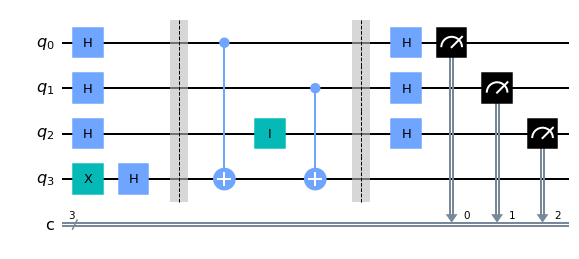

In [27]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.x(n)
bv_circuit.h(n)
#bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = '011'
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q , n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw(output='mpl')

The oracle above utilizes the fact that the CNOT gate with a $|-\rangle$ in the second register adds a phase shift

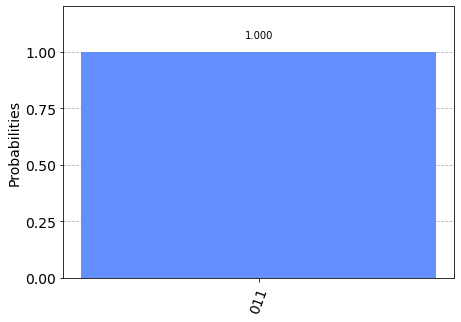

In [28]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(bv_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)


### Run on real quantum device

In [6]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)


/opt/anaconda3/envs/Quantum_Computing/lib/python3.9/site-packages/qiskit/providers/ibmq/ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_belem


In [7]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_bv_circuit = transpile(bv_circuit, backend)
qobj = assemble(transpiled_bv_circuit, shots=shots)
job = backend.run(qobj)

job_monitor(job, interval=2)


Job Status: job has successfully run


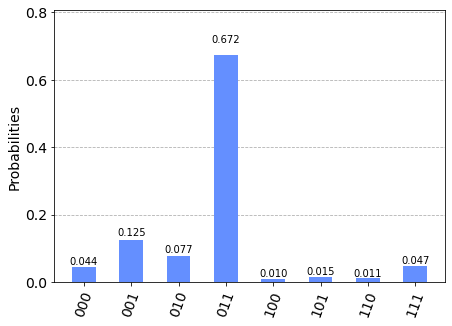

In [8]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)
